<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-23_13_48_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [31]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import MNIST as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [33]:
batch_size = 256
epochs = 2
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [34]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [35]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

In [36]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [37]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [38]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [39]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 0

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [40]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = Adam(model.parameters())

    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [41]:
model = Module().to(device)

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

Task 0 Start!
Epoch	1	Acc:  0.8159, Loss:  0.0033
Epoch	2	Acc:  0.8917, Loss:  0.0017
Task 0 Acc:  0.9075, Loss:  0.0014
Task 1 Acc:  0.1166, Loss:  0.0173

Task 1 Start!
Epoch	1	Acc:  0.5796, Loss:  0.0057
Epoch	2	Acc:  0.8611, Loss:  0.0019
Task 0 Acc:  0.3631, Loss:  0.0099
Task 1 Acc:  0.8928, Loss:  0.0016



 - Task 0

Accuracy 0.3631
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.63      0.64      0.63       980
     1 - one       0.00      0.00      0.00      1135
     2 - two       0.33      0.26      0.29      1032
   3 - three       0.54      0.37      0.44      1010
    4 - four       0.15      0.64      0.25       982
    5 - five       0.19      0.04      0.07       892
     6 - six       0.56      0.63      0.59       958
   7 - seven       0.65      0.45      0.53      1028
   8 - eight       0.35      0.18      0.24       974
    9 - nine       0.54      0.44      0.49      1009

    accuracy                           0.36     10000
   macro avg       0.39      0.37      0.35     10000
weighted avg       0.39      0.36      0.35     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


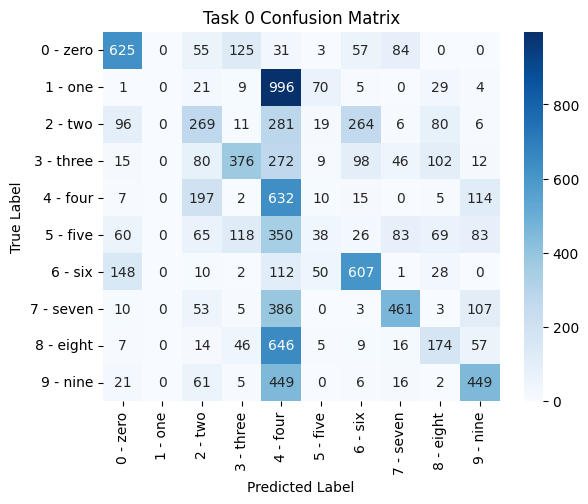

In [42]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.8928
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.93      0.98      0.95       980
     1 - one       0.95      0.96      0.96      1135
     2 - two       0.90      0.84      0.87      1032
   3 - three       0.87      0.87      0.87      1010
    4 - four       0.87      0.92      0.89       982
    5 - five       0.85      0.82      0.83       892
     6 - six       0.91      0.93      0.92       958
   7 - seven       0.92      0.89      0.90      1028
   8 - eight       0.85      0.84      0.84       974
    9 - nine       0.87      0.87      0.87      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



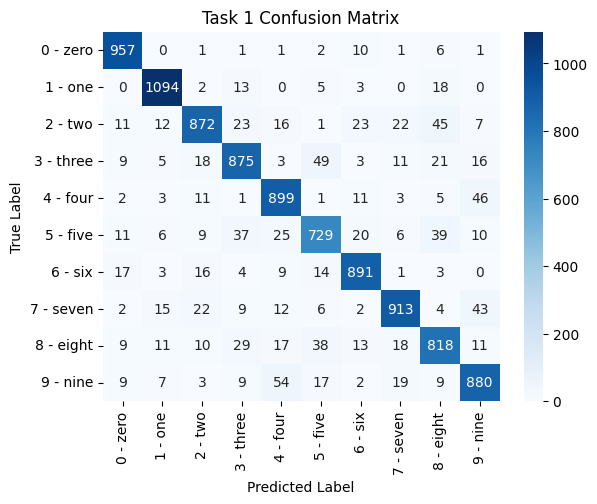

In [43]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.1.weight
torch.Size([10, 784])
Max fisher is 0.21753 and it's parameter diff is 0.03705
Min Parameter diff is 0.25394 and it's fisher is 0.00000


<ipython-input-44-1c49247e833c>:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 640x480 with 0 Axes>

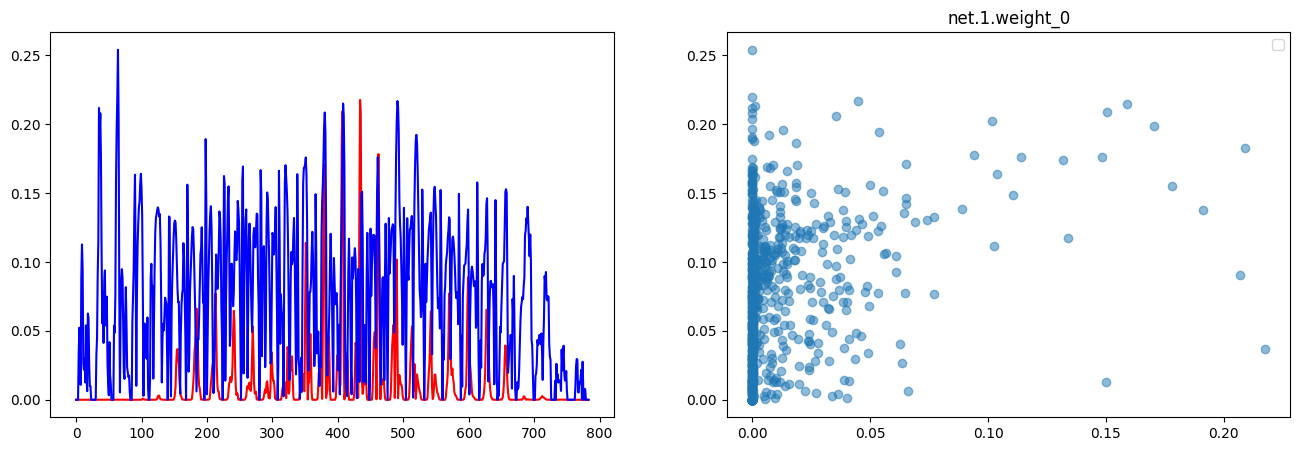

Max fisher is 0.63586 and it's parameter diff is 0.17090
Min Parameter diff is 0.31495 and it's fisher is 0.26619


<Figure size 640x480 with 0 Axes>

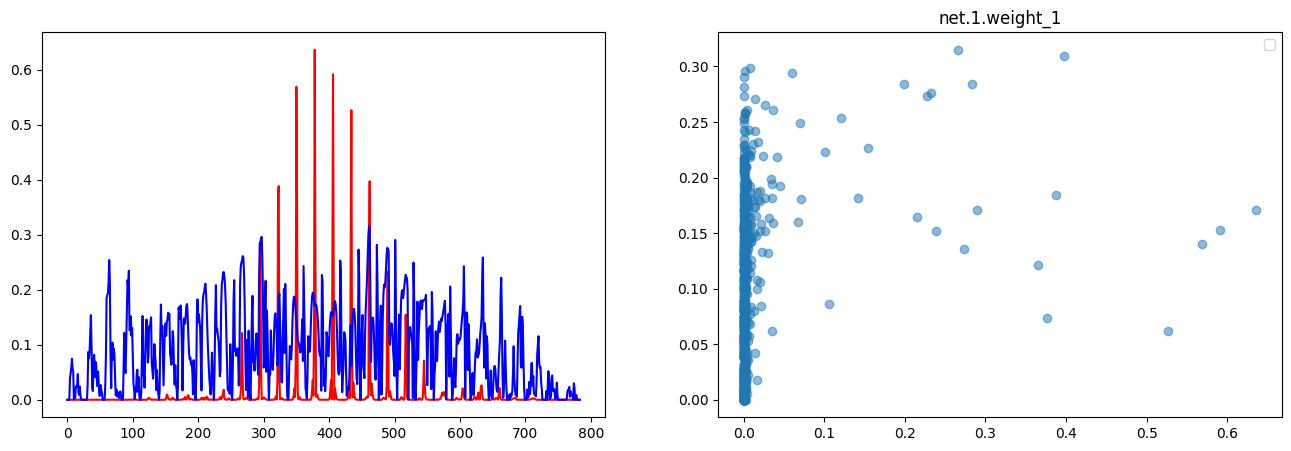

Max fisher is 0.16836 and it's parameter diff is 0.07719
Min Parameter diff is 0.23728 and it's fisher is 0.00996


<Figure size 640x480 with 0 Axes>

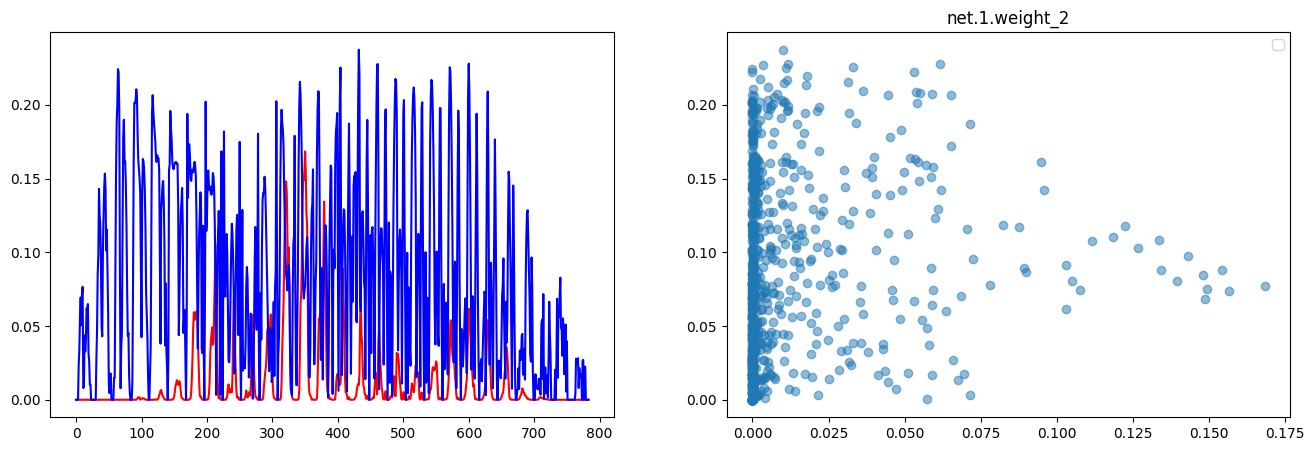

Max fisher is 0.19921 and it's parameter diff is 0.00427
Min Parameter diff is 0.24345 and it's fisher is 0.00008


<Figure size 640x480 with 0 Axes>

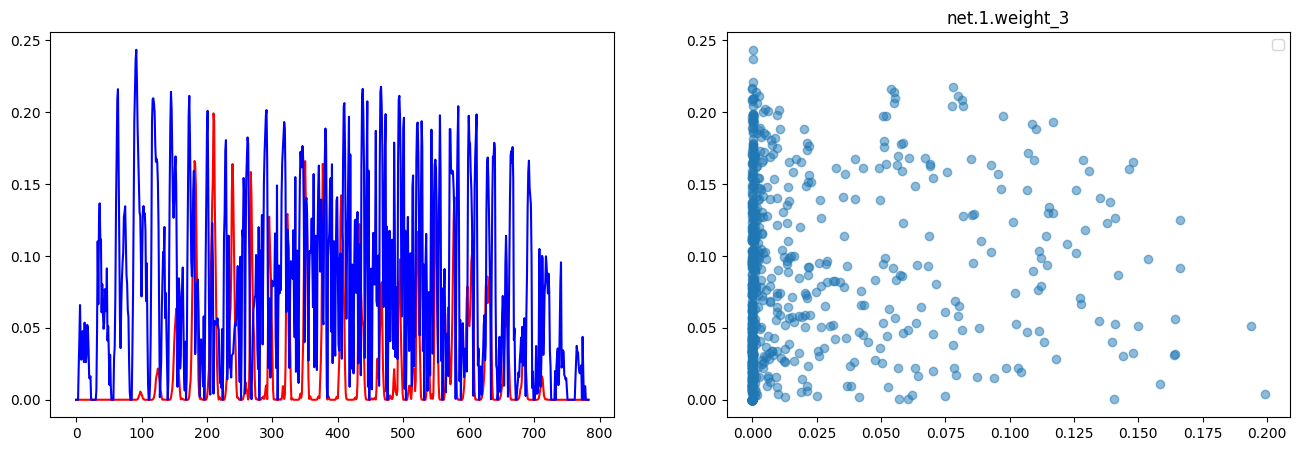

Max fisher is 0.47268 and it's parameter diff is 0.06501
Min Parameter diff is 0.31902 and it's fisher is 0.00000


<Figure size 640x480 with 0 Axes>

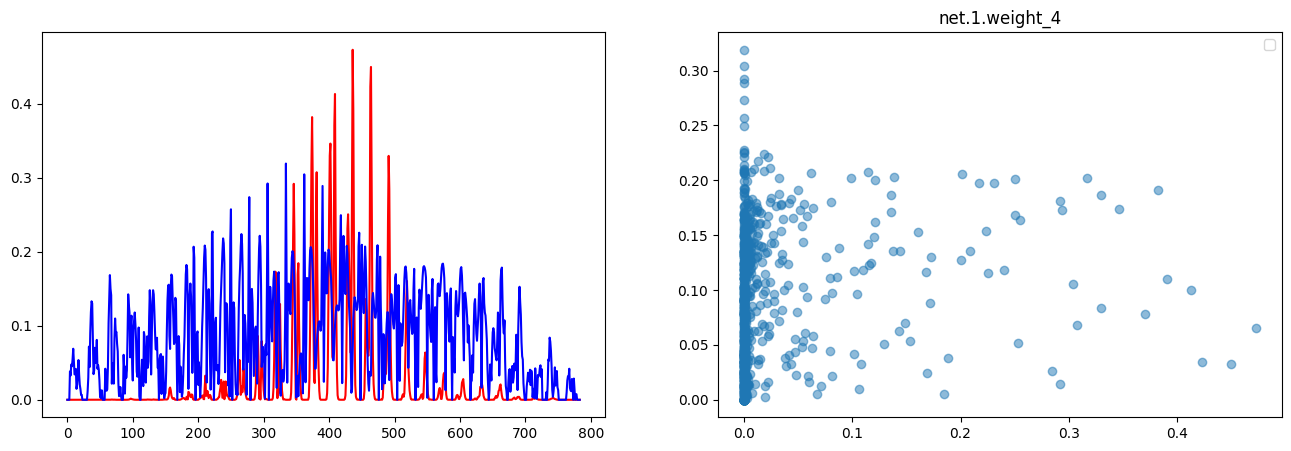

Max fisher is 0.35855 and it's parameter diff is 0.01013
Min Parameter diff is 0.28134 and it's fisher is 0.00004


<Figure size 640x480 with 0 Axes>

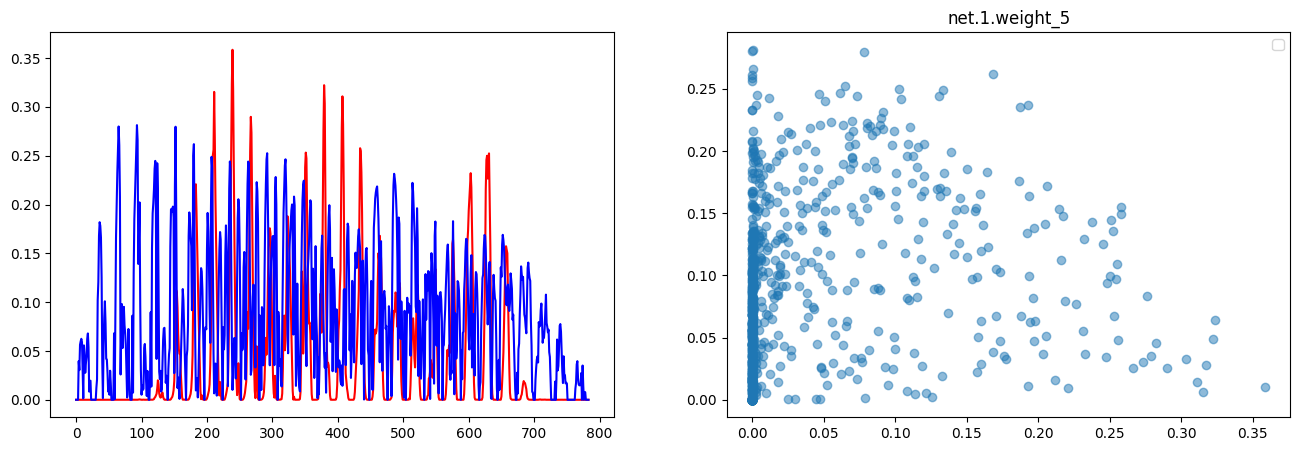

Max fisher is 0.13300 and it's parameter diff is 0.16725
Min Parameter diff is 0.21738 and it's fisher is 0.00004


<Figure size 640x480 with 0 Axes>

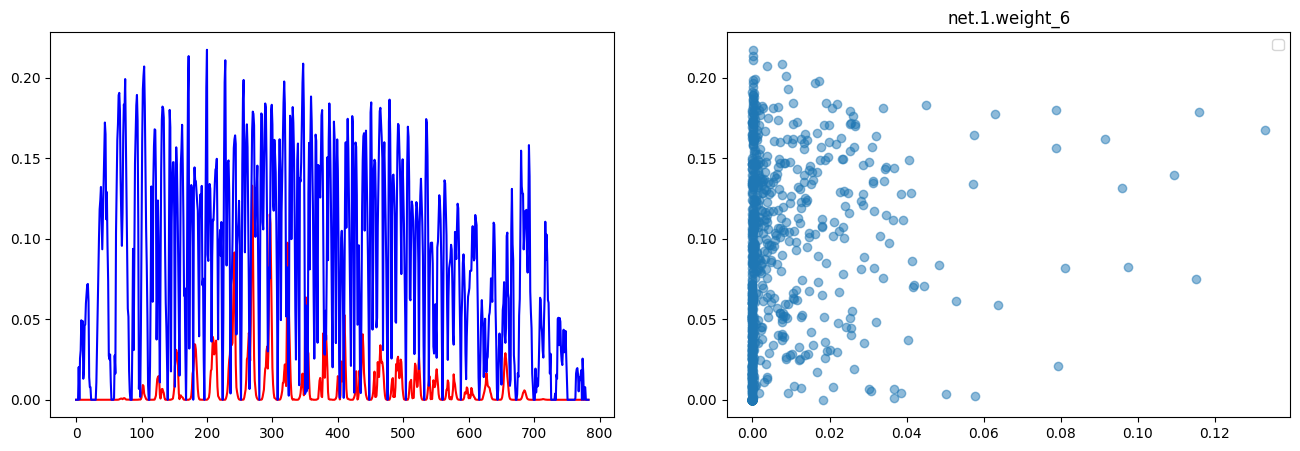

Max fisher is 0.18750 and it's parameter diff is 0.16378
Min Parameter diff is 0.23094 and it's fisher is 0.17527


<Figure size 640x480 with 0 Axes>

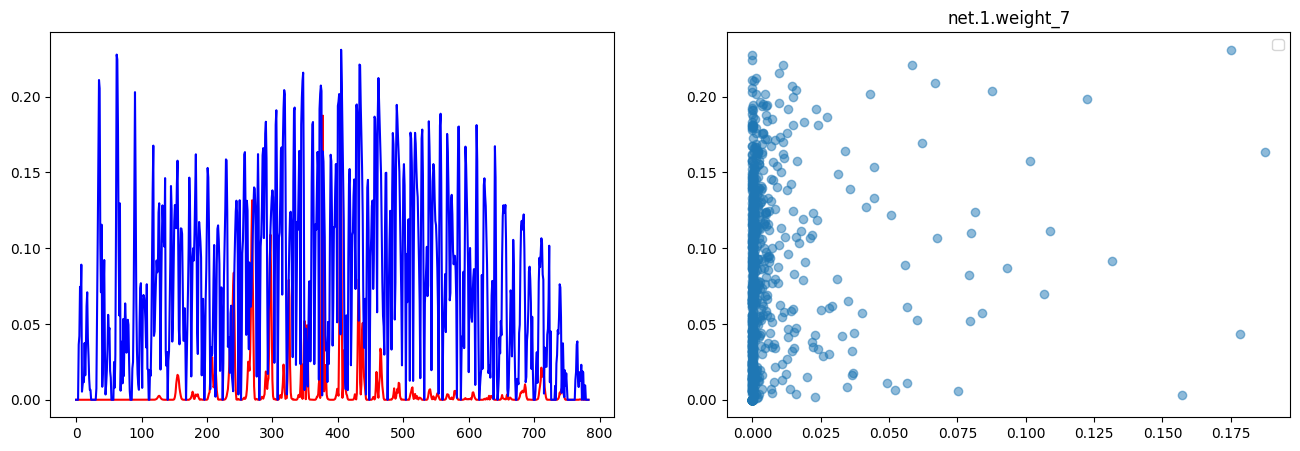

Max fisher is 0.41557 and it's parameter diff is 0.01708
Min Parameter diff is 0.23781 and it's fisher is 0.00000


<Figure size 640x480 with 0 Axes>

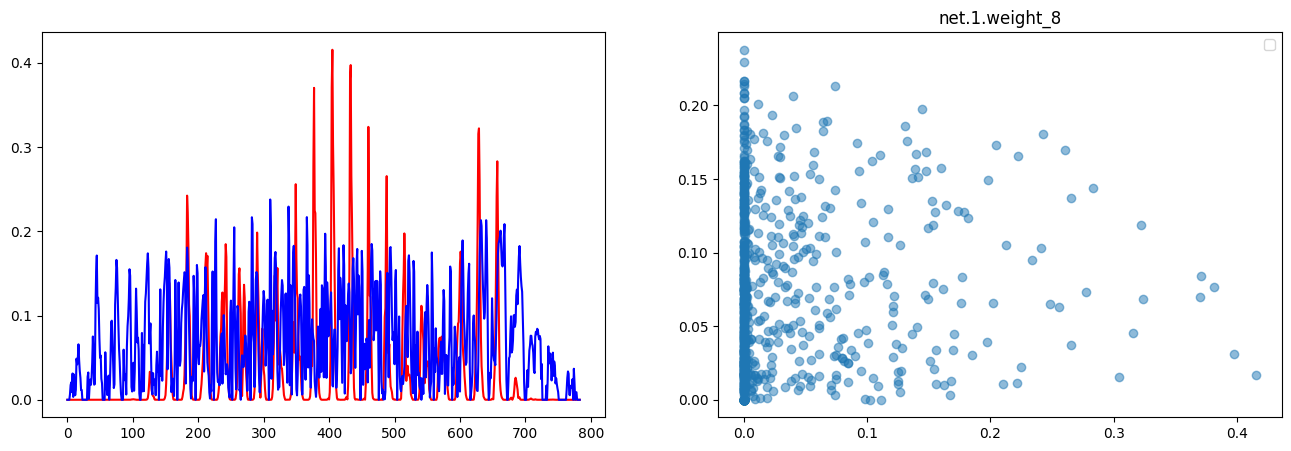

Max fisher is 0.20585 and it's parameter diff is 0.05648
Min Parameter diff is 0.26616 and it's fisher is 0.00000


<Figure size 640x480 with 0 Axes>

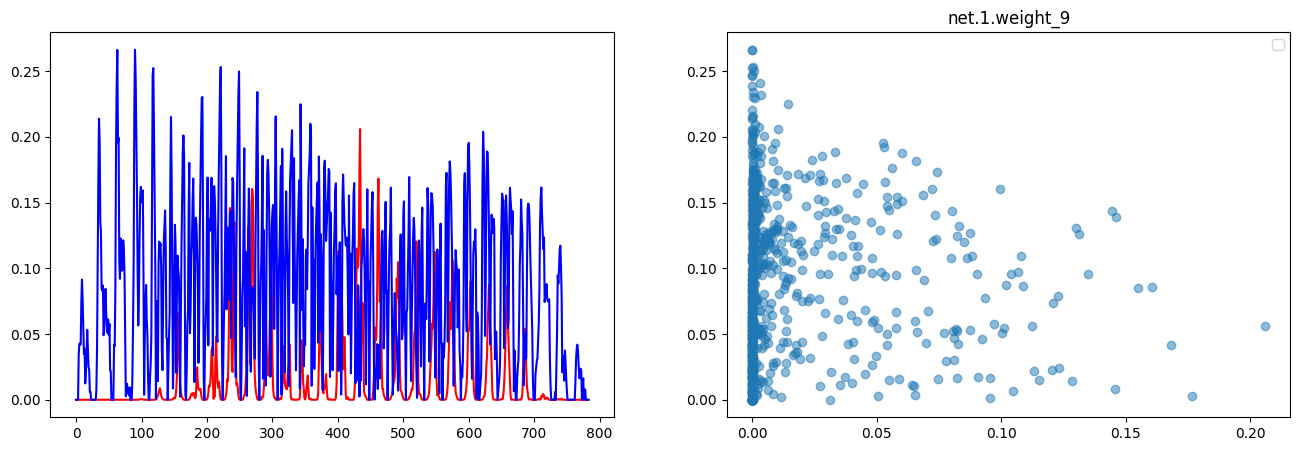


net.1.bias
torch.Size([10])
Max fisher is 0.46413 and it's parameter diff is 0.10679
Min Parameter diff is 0.18676 and it's fisher is 0.02344


<Figure size 640x480 with 0 Axes>

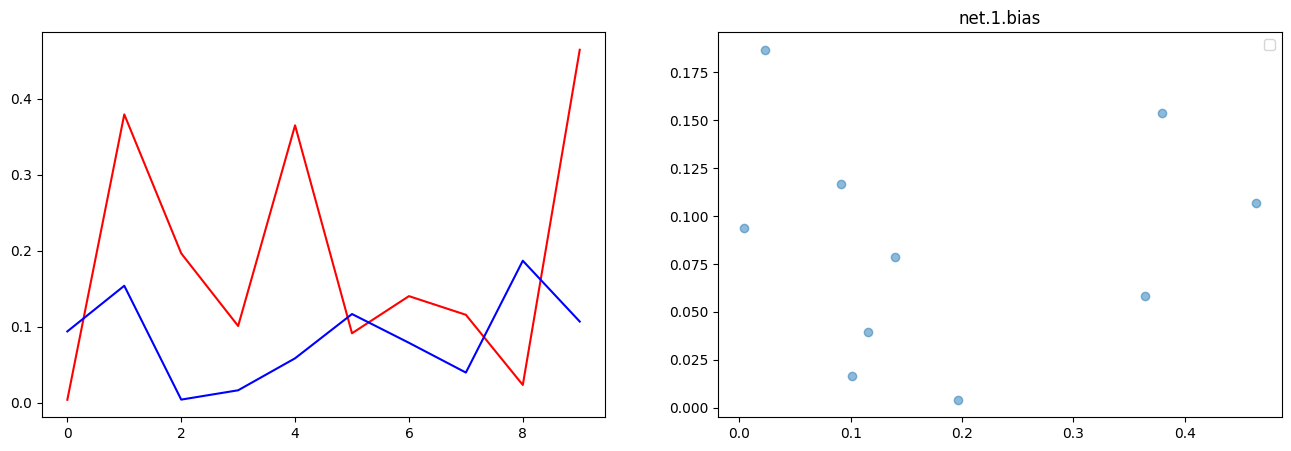

In [44]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')

  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.legend()
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i], optim_para[0][name][i], param[i], f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [45]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-23_13_48_01
